<a href="https://colab.research.google.com/github/anki2208/Bike-Rental-Count-Prediction/blob/main/Bike_Rental_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import os

In [39]:
from google.colab import files
uploaded = files.upload()

Saving day.csv to day.csv


In [41]:
import io 
bike_df = pd.read_csv(io.BytesIO(uploaded['day.csv']))
bike_df.head(5)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [42]:
# Renaming the columns
bike_df.rename(columns={'instant':'rec_id','dteday':'datetime','yr':'year','mnth':'month','weathersit':'weather_condition',
                       'hum':'humidity','cnt':'total_count'},inplace=True)
bike_df.head()

,rec_id,datetime,season,year,month,holiday,weekday,workingday,weather_condition,temp,atemp,humidity,windspeed,casual,registered,total_count
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [43]:
#Type casting the datetime and numerical attributes to category

bike_df['datetime']=pd.to_datetime(bike_df.datetime)

bike_df['season']=bike_df.season.astype('category')
bike_df['year']=bike_df.year.astype('category')
bike_df['month']=bike_df.month.astype('category')
bike_df['holiday']=bike_df.holiday.astype('category')
bike_df['weekday']=bike_df.weekday.astype('category')
bike_df['workingday']=bike_df.workingday.astype('category')
bike_df['weather_condition']=bike_df.weather_condition.astype('category')

In [44]:
#Missing values in dataset
bike_df.isnull().sum()

rec_id               0
datetime             0
season               0
year                 0
month                0
holiday              0
weekday              0
workingday           0
weather_condition    0
temp                 0
atemp                0
humidity             0
windspeed            0
casual               0
registered           0
total_count          0
dtype: int64

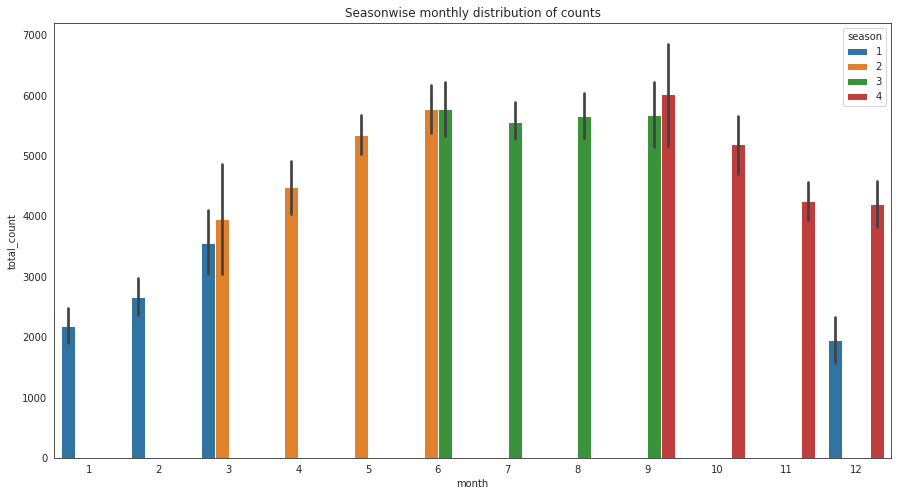

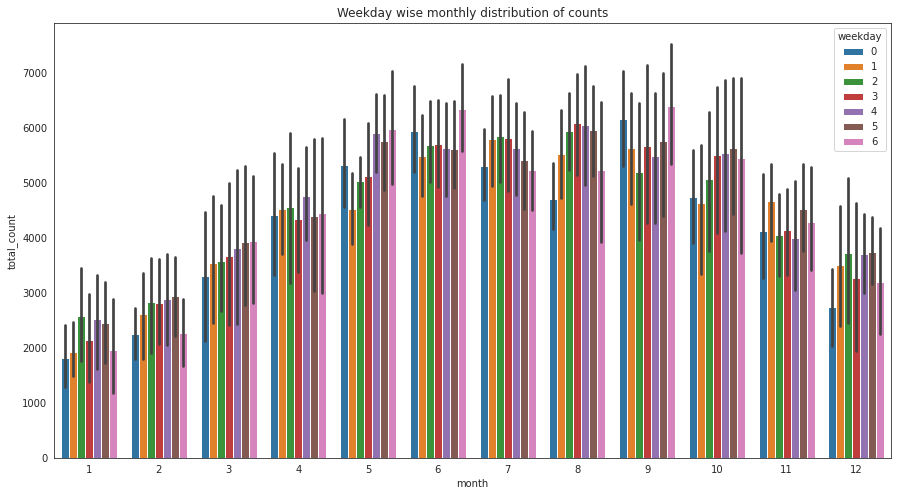

In [45]:
fig,ax=plt.subplots(figsize=(15,8))
sns.set_style('white')
#Bar plot for seasonwise monthly distribution of counts
sns.barplot(x='month',y='total_count',data=bike_df[['month','total_count','season']],hue='season',ax=ax)
ax.set_title('Seasonwise monthly distribution of counts')
plt.show()
#Bar plot for weekday wise monthly distribution of counts
fig,ax1=plt.subplots(figsize=(15,8))
sns.barplot(x='month',y='total_count',data=bike_df[['month','total_count','weekday']],hue='weekday',ax=ax1)
ax1.set_title('Weekday wise monthly distribution of counts')
plt.show()

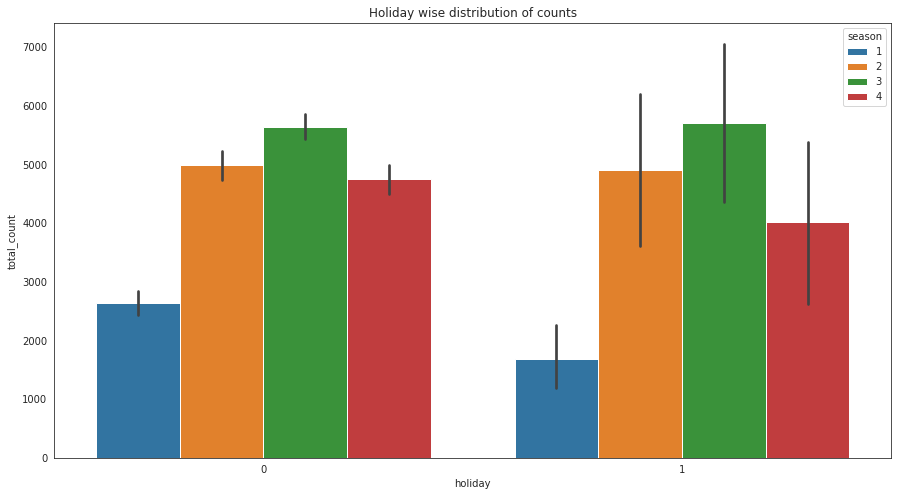

In [46]:
fig,ax=plt.subplots(figsize=(15,8))
#Barplot for Holiday distribution of counts
sns.barplot(data=bike_df,x='holiday',y='total_count',hue='season')
ax.set_title('Holiday wise distribution of counts')
plt.show()

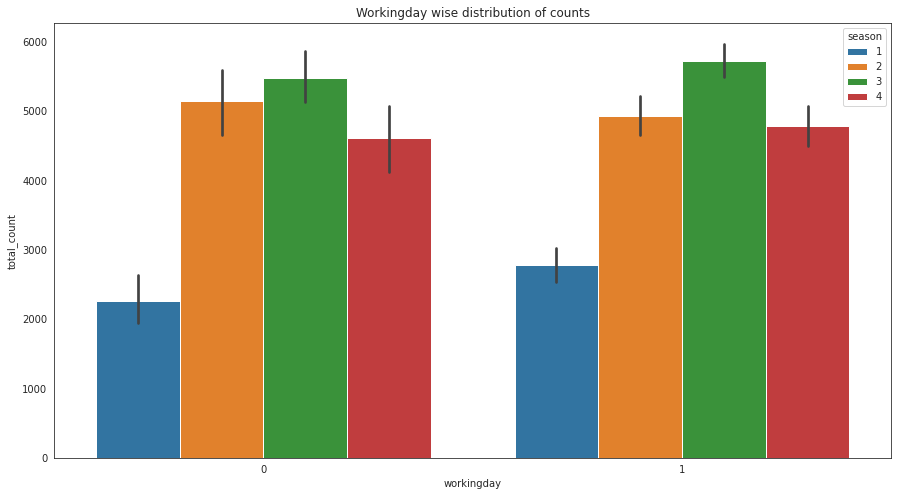

In [47]:
fig,ax=plt.subplots(figsize=(15,8))
#Bar plot for workingday distribution of counts
sns.barplot(data=bike_df,x='workingday',y='total_count',hue='season')
ax.set_title('Workingday wise distribution of counts')
plt.show()

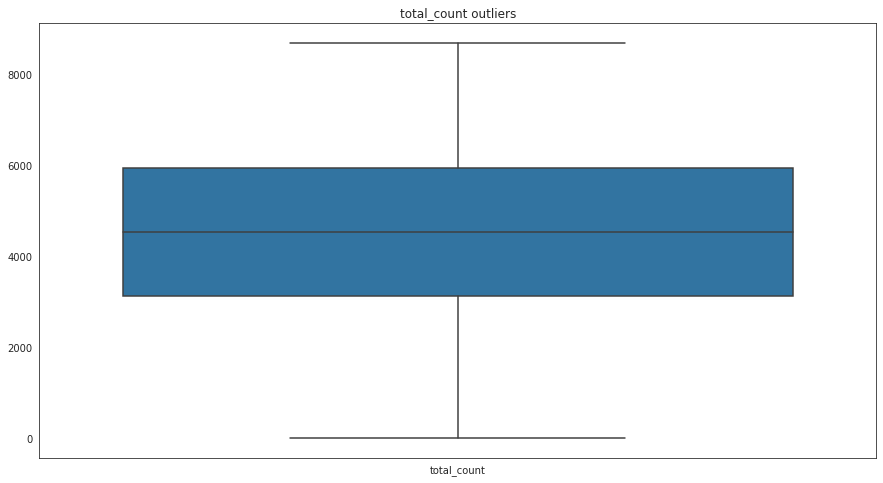

In [48]:
fig,ax=plt.subplots(figsize=(15,8))
#Boxplot for total_count outliers
sns.boxplot(data=bike_df[['total_count']])
ax.set_title('total_count outliers')
plt.show()

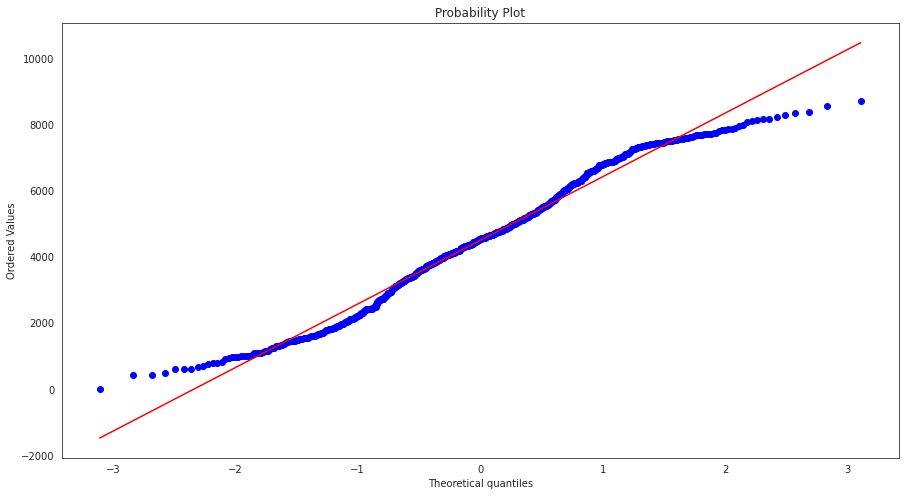

In [49]:
import scipy
from scipy import stats
#Normal plot
fig=plt.figure(figsize=(15,8))
stats.probplot(bike_df.total_count.tolist(),dist='norm',plot=plt)
plt.show()

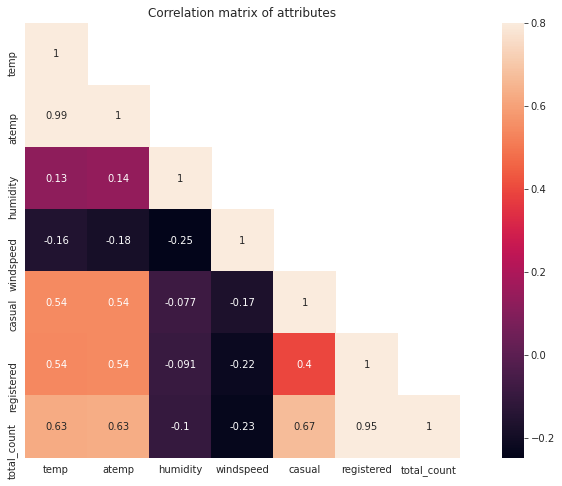

In [50]:
#Create the correlation matrix
correMtr=bike_df[["temp","atemp","humidity","windspeed","casual","registered","total_count"]].corr()
mask=np.array(correMtr)
mask[np.tril_indices_from(mask)]=False
#Heat map for correlation matrix of attributes
fig,ax=plt.subplots(figsize=(15,8))
sns.heatmap(correMtr,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
ax.set_title('Correlation matrix of attributes')
plt.show()

In [52]:
from sklearn import preprocessing,metrics,linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict,train_test_split

In [53]:
#Split the dataset into the train and test data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(bike_df.iloc[:,0:-3],bike_df.iloc[:,-1],test_size=0.3, random_state=42)

#Reset train index values
X_train.reset_index(inplace=True)
y_train=y_train.reset_index()

# Reset train index values
X_test.reset_index(inplace=True)
y_test=y_test.reset_index()

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
print(y_train.head())
print(y_test.head())


(511, 14) (220, 14) (511, 2) (220, 2)
   index  total_count
0    223         4905
1    684         5445
2    685         5698
3    163         5020
4    394         3624
   index  total_count
0    703         6606
1     33         1550
2    300         3747
3    456         6041
4    633         7538


In [54]:
#Create a new dataset for train attributes
train_attributes=X_train[['season','month','year','weekday','holiday','workingday','weather_condition','humidity','temp','windspeed']]
#Create a new dataset for test attributes
test_attributes=X_test[['season','month','year','weekday','holiday','workingday','humidity','temp','windspeed','weather_condition']]
#categorical attributes
cat_attributes=['season','holiday','workingday','weather_condition','year']
#numerical attributes
num_attributes=['temp','windspeed','humidity','month','weekday']

In [55]:
#To get dummy variables to encode the categorical features to numeric
train_encoded_attributes=pd.get_dummies(train_attributes,columns=cat_attributes)
print('Shape of transfomed dataframe::',train_encoded_attributes.shape)
train_encoded_attributes.head(5)

Shape of transfomed dataframe:: (511, 18)


,month,weekday,humidity,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,8,5,0.415000,0.708333,0.125621,0,0,1,0,1,0,0,1,1,0,0,1,0
1,11,4,0.620417,0.321667,0.152987,0,0,0,1,1,0,0,1,0,1,0,0,1
2,11,5,0.524583,0.345000,0.171025,0,0,0,1,1,0,0,1,1,0,0,0,1
3,6,1,0.494583,0.635000,0.305350,0,1,0,0,1,0,0,1,1,0,0,1,0
4,1,1,0.400833,0.269167,0.215792,1,0,0,0,1,0,0,1,1,0,0,0,1


In [56]:
X_train=train_encoded_attributes
y_train=y_train.total_count.values

In [57]:
# LINEAR REGRESSION MODEL
lr_model=linear_model.LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
#Accuracy of the model
lr=lr_model.score(X_train,y_train)
print('Accuracy of the model :',lr)
print('Model coefficients :',lr_model.coef_)
print('Model intercept value :',lr_model.intercept_)

Accuracy of the model : 0.8164644195384456
Model coefficients : [  -25.67964022    69.04524677  -946.11648038  5226.31938879
 -2526.83165381  -960.7979661    233.21695025   -71.46895155
   799.0499674    228.88041979  -228.88041979   -78.248613
    78.248613     791.45676629   269.60191415 -1061.05868044
  -991.62009894   991.62009894]
Model intercept value : 2138.0499819507886


In [59]:
predict=cross_val_predict(lr_model,X_train,y_train,cv=3)
predict

array([ 5248.7578435 ,  5038.5615668 ,  5806.79339316,  4353.94868702,
        3738.02165465,  6781.13199665,  6258.53686563,  3802.32154757,
        4679.69060739,  3413.26938345,  5382.26926795,  3103.26413427,
        4340.14502978,  5792.02135524,  4357.90482085,  6307.47067538,
        4382.53420011,  3356.51602988,   722.55880035,   542.99629923,
        7419.07107033,  3747.2639444 ,  5282.38323084,  5494.01243603,
        6941.05375802,  7322.95928003,  3629.5886932 ,  3571.12912785,
         985.45343201,  4884.05952005,  1644.73801661,  1708.88196943,
        1689.90104258,  1295.63879625,  4891.47726849,  5507.81236621,
        6015.17425095,  4180.63057735,  5075.38404498,  5941.56769703,
        6400.40498745,  4215.81855312,  5962.38814912,  6052.71452714,
        3345.73314148,  4096.72004817,  1465.44713372,  3603.17274178,
        4587.89942466,  6650.65699064,  1719.93360965,  6128.15135134,
        6439.33525805,  3277.84008997,  4592.0786174 ,  3194.61235   ,
      

In [60]:
# Model evalution metrics
#R-squared scores
from sklearn.model_selection import cross_val_score
r2_scores = cross_val_score(lr_model, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.800187666590512


In [61]:
test_encoded_attributes=pd.get_dummies(test_attributes,columns=cat_attributes)
print('Shape of transformed dataframe :',test_encoded_attributes.shape)
test_encoded_attributes.head(5)

Shape of transformed dataframe : (220, 18)


,month,weekday,humidity,temp,windspeed,season_1,season_2,season_3,season_4,holiday_0,holiday_1,workingday_0,workingday_1,weather_condition_1,weather_condition_2,weather_condition_3,year_0,year_1
0,12,2,0.733750,0.475833,0.174129,0,0,0,1,1,0,0,1,1,0,0,0,1
1,2,4,0.437826,0.186957,0.277752,1,0,0,0,1,0,0,1,1,0,0,1,0
2,10,5,0.585833,0.330833,0.229479,0,0,0,1,1,0,0,1,0,1,0,1,0
3,4,0,0.676250,0.425833,0.172267,0,1,0,0,1,0,1,0,0,1,0,0,1
4,9,2,0.570000,0.550000,0.236321,0,0,0,1,1,0,0,1,1,0,0,0,1


In [62]:
#Test dataset for prediction
X_test=test_encoded_attributes
y_test=y_test.total_count.values

In [63]:
#predict the model
lr_pred=lr_model.predict(X_test)
lr_pred

array([6209.88825553, 1370.06947696, 3205.55849425, 4830.84047714,
       6672.32546573, 6947.08528843,  677.27161672, 1930.19985524,
       6960.37730963, 6853.05955207, 2796.28434677, 2106.72243383,
       4459.62259931, 5490.76139515, 2170.94843429, 1815.33408557,
       2159.74379601, 7467.50546535, 5480.85944359, 2610.61755996,
       6931.75427888, 7827.1631451 , 5537.40521413, 1260.01881383,
       1239.58201011, 4482.33688527, 2513.51830313, 6726.24746139,
       3855.1594353 , 5814.58439125, 3101.81978124, 4246.0992367 ,
       6352.07728202, 6798.30987499, 5789.57985271, 5421.74100249,
       6682.04863246, 5853.2718865 , 3185.1535458 ,  800.50999346,
       4499.93257987, 3739.00277023, 6910.64022695, 4066.40570202,
       6915.07188273, 1642.61427789, 4803.6959788 , 4710.75028654,
       6375.22762156, 4601.3646879 , 3109.14207514, 2841.35338182,
       1820.66354148, 5587.80018272, 4624.6432182 , 4086.58284626,
       4701.90383703, 3042.28041307, 4366.68721862, 6624.05914

In [64]:
import math
#Root mean square error 
rmse=math.sqrt(metrics.mean_squared_error(y_test,lr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,lr_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)

Root mean square error : 782.4072817767152
Mean absolute error : 594.5075464350734


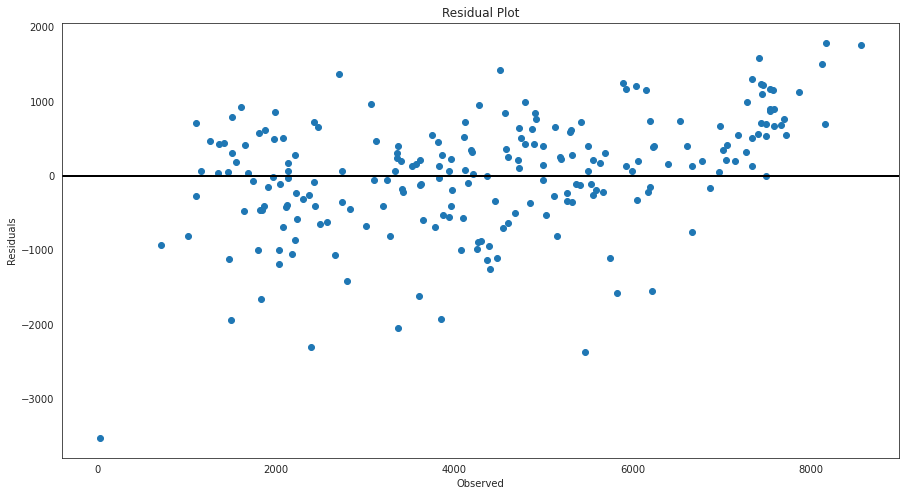

In [65]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_test, y_test-lr_pred)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot")
plt.show()

In [66]:
# Decision Tree
#training the model
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(min_samples_split=2,max_leaf_nodes=10)

In [67]:
#Fit the trained model
dtr.fit(X_train,y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [68]:
#Accuracy score of the model
dtr_score=dtr.score(X_train,y_train)
print('Accuracy of model :',dtr_score)

Accuracy of model : 0.8082151777539757


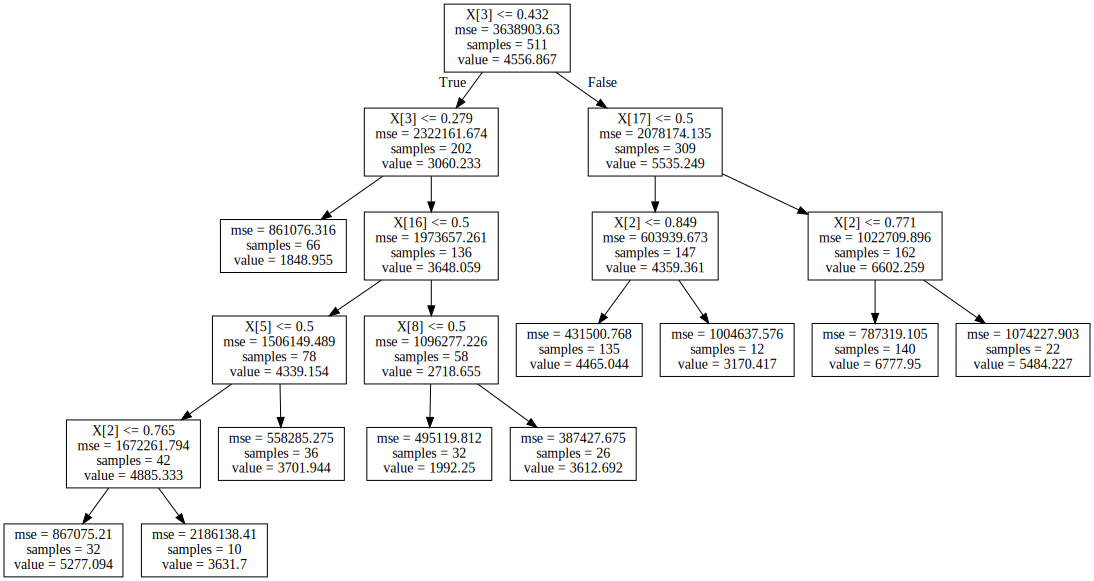

In [69]:
#Plot the learned model
from sklearn import tree
import pydot
import graphviz

# export the learned model to tree
dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [70]:
#R-squared scores
r2_scores = cross_val_score(dtr, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.7460808156442775


In [71]:
#predict the model
dtr_pred=dtr.predict(X_test)
dtr_pred

array([6777.95      , 1848.95454545, 3612.69230769, 5277.09375   ,
       6777.95      , 6777.95      , 1848.95454545, 1992.25      ,
       6777.95      , 6777.95      , 1848.95454545, 1992.25      ,
       4465.04444444, 5277.09375   , 1992.25      , 1992.25      ,
       1992.25      , 6777.95      , 4465.04444444, 1848.95454545,
       6777.95      , 6777.95      , 5277.09375   , 1848.95454545,
       1992.25      , 4465.04444444, 1992.25      , 6777.95      ,
       1848.95454545, 5277.09375   , 1848.95454545, 4465.04444444,
       6777.95      , 6777.95      , 6777.95      , 5484.22727273,
       6777.95      , 6777.95      , 4465.04444444, 1848.95454545,
       4465.04444444, 1848.95454545, 6777.95      , 4465.04444444,
       6777.95      , 3612.69230769, 4465.04444444, 6777.95      ,
       6777.95      , 5484.22727273, 4465.04444444, 1848.95454545,
       1992.25      , 4465.04444444, 4465.04444444, 4465.04444444,
       3170.41666667, 4465.04444444, 4465.04444444, 6777.95   

In [72]:
#Root mean square error
rmse=math.sqrt(metrics.mean_squared_error(y_test,dtr_pred))
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,dtr_pred)
print('Root mean square error :',rmse)
print('Mean absolute error :',mae)

Root mean square error : 925.7976022448886
Mean absolute error : 667.8169018859927


In [73]:
#Random Forest
#Training the model
from sklearn.ensemble import RandomForestRegressor
X_train=train_encoded_attributes
rf=RandomForestRegressor(n_estimators=200)

In [74]:
#Fit the trained model
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [75]:
#accuracy of the model
rf_score =rf.score(X_train,y_train)
print('Accuracy of the model :',rf_score)

Accuracy of the model : 0.9804285830368142


In [76]:
#R-squared scores
r2_scores = cross_val_score(rf, X_train, y_train, cv=3)
print('R-squared scores :',np.average(r2_scores))

R-squared scores : 0.8484339918559307


In [77]:
#predict the model
X_test=test_encoded_attributes
rf_pred=rf.predict(X_test)
rf_pred

array([6512.39 , 1562.58 , 3436.28 , 5231.09 , 7459.165, 7248.165,
       1457.795, 2301.26 , 7325.01 , 6489.82 , 2040.795, 2905.48 ,
       4974.645, 5087.99 , 2020.44 , 2153.89 , 2247.51 , 7834.295,
       5010.28 , 2483.88 , 7504.555, 6119.07 , 5843.585, 1759.815,
       1727.9  , 4694.015, 1937.085, 7220.16 , 3210.045, 5706.415,
       2950.85 , 4059.25 , 6658.245, 7378.99 , 6158.785, 5321.48 ,
       7285.17 , 6321.94 , 3166.665,  947.825, 3820.5  , 3315.53 ,
       7276.18 , 4512.615, 6920.22 , 2199.96 , 4315.76 , 5456.82 ,
       6595.67 , 4049.88 , 4251.01 , 2926.6  , 2309.175, 4395.505,
       4631.855, 4228.415, 3477.405, 3783.04 , 4307.085, 6509.93 ,
       6155.67 , 6885.61 , 2014.68 , 7392.845, 6488.84 , 6393.82 ,
       5930.54 , 4379.25 , 1789.665, 7239.7  , 3807.57 , 2023.01 ,
       3155.49 , 4032.505, 4293.695, 3835.215, 4700.775, 4528.385,
       1345.575, 4338.47 , 2464.455, 1963.825, 4950.58 , 4193.4  ,
       3661.46 , 3387.505, 3972.325, 3730.875, 3456.755, 3314.

In [78]:
#Root mean square error
rmse = math.sqrt(metrics.mean_squared_error(y_test,rf_pred))
print('Root mean square error :',rmse)
#Mean absolute error
mae=metrics.mean_absolute_error(y_test,rf_pred)
print('Mean absolute error :',mae)

Root mean square error : 638.9727695465057
Mean absolute error : 424.88179545454545


In [79]:
# Final Model for for predicting the bike rental count on daily basis
Bike_df1=pd.DataFrame(y_test,columns=['y_test'])
Bike_df2=pd.DataFrame(rf_pred,columns=['rf_pred'])
Bike_predictions=pd.merge(Bike_df1,Bike_df2,left_index=True,right_index=True)
Bike_predictions.to_csv('Bike_Renting_Python.csv')
Bike_predictions

,y_test,rf_pred
0,6606,6512.390
1,1550,1562.580
2,3747,3436.280
3,6041,5231.090
4,7538,7459.165
...,...,...
215,2659,3961.905
216,7338,7265.665
217,6978,6840.745
218,4795,3456.100
